# AutoEncoder 실습
Simple AutoEncoder모델로 mnist 데이터셋을 학습

In [1]:
from IPython.display import Image, SVG
import matplotlib.pyplot as plt

%matplotlib inline

import numpy as np
import tensorflow.keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from tensorflow.keras import regularizers

## (1) 데이터셋 준비

In [2]:
(x_train, _), (x_test, _) = mnist.load_data()

# max_value = float(x_train.max())
max_value = 255
x_train = x_train.astype('float32') / max_value
x_test = x_test.astype('float32') / max_value

In [3]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [4]:
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

(x_train.shape, x_test.shape)

((60000, 784), (10000, 784))

input 데이터의 차원과, encoder로 압축된 vector의 차원을 결정

In [5]:
input_dim = x_train.shape[1]
z_dim = 32

## (2) 모델링

keras.regularizers : layer에 regularizer를 입력하여 해당 layer의 weight들을 정규화

https://keras.io/regularizers/

In [6]:
from tensorflow.keras import regularizers

In [7]:
class simple_AE(Model):
    def __init__(self, input_dim=784, z_dim=36):
        x = Input(shape=(input_dim,))
#         z = Dense(z_dim, activation='relu')(x)
        z = Dense(z_dim, activation='relu', activity_regularizer=regularizers.l1(10e-5))(x) ## Dense layer에 regularization term 추가
        y = Dense(input_dim, activation='sigmoid')(z)

        super().__init__(x, y)

        self.x = x
        self.z = z
        self.z_dim = z_dim

    def Encoder(self):
        return Model(self.x, self.z)

    def Decoder(self):
        z_shape = (self.z_dim,)
        z = Input(shape=z_shape)
        y_layer = self.layers[-1]
        y = y_layer(z)
        return Model(z, y)

In [8]:
simple_AE_model =simple_AE(input_dim, z_dim)
simple_AE_model.compile(optimizer='adam', loss='binary_crossentropy')
simple_AE_model.summary()

Model: "simple_ae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dense_1 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


## (3) 모델 학습

In [9]:
simple_AE_model.fit(x_train, x_train, epochs=100, batch_size=256, shuffle=True, validation_split=0.2)

Epoch 1/100
188/188 [==============================] - 1s 3ms/step - loss: 0.3007 - val_loss: 0.2049
Epoch 2/100
188/188 [==============================] - 0s 2ms/step - loss: 0.1872 - val_loss: 0.1720
Epoch 3/100
188/188 [==============================] - 0s 2ms/step - loss: 0.1627 - val_loss: 0.1541
Epoch 4/100
188/188 [==============================] - 0s 2ms/step - loss: 0.1483 - val_loss: 0.1426
Epoch 5/100
188/188 [==============================] - 0s 3ms/step - loss: 0.1383 - val_loss: 0.1339
Epoch 6/100
188/188 [==============================] - 0s 3ms/step - loss: 0.1304 - val_loss: 0.1272
Epoch 7/100
188/188 [==============================] - 0s 3ms/step - loss: 0.1244 - val_loss: 0.1220
Epoch 8/100
188/188 [==============================] - 0s 3ms/step - loss: 0.1196 - val_loss: 0.1181
Epoch 9/100
188/188 [==============================] - 0s 2ms/step - loss: 0.1159 - val_loss: 0.1148
Epoch 10/100
188/188 [==============================] - 1s 3ms/step - loss: 0.1131 - val_lo

188/188 [==============================] - 0s 2ms/step - loss: 0.0979 - val_loss: 0.0989
Epoch 80/100
188/188 [==============================] - 0s 3ms/step - loss: 0.0978 - val_loss: 0.0988
Epoch 81/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0978 - val_loss: 0.0988
Epoch 82/100
188/188 [==============================] - 0s 3ms/step - loss: 0.0978 - val_loss: 0.0988
Epoch 83/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0977 - val_loss: 0.0987
Epoch 84/100
188/188 [==============================] - 0s 3ms/step - loss: 0.0977 - val_loss: 0.0987
Epoch 85/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0976 - val_loss: 0.0986
Epoch 86/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0976 - val_loss: 0.0986
Epoch 87/100
188/188 [==============================] - 0s 3ms/step - loss: 0.0976 - val_loss: 0.0986
Epoch 88/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0975 - val_loss: 

## (4) 모델 사용하기

AutoEncoder 모델의 Encoder와 Decoder를 따로 불러와, latent vector, 복원된 이미지, 원본 이미지 plot

In [10]:
def show_ae(autoencoder, x_test):
    encoder = autoencoder.Encoder()
    decoder = autoencoder.Decoder()

    encoded_imgs = encoder.predict(x_test)
    decoded_imgs = decoder.predict(encoded_imgs)

    n = 10
    plt.figure(figsize=(20, 6))
    for i in range(n):

        ax = plt.subplot(3, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + n)
        plt.stem(encoded_imgs[i].reshape(-1), use_line_collection=True)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + n + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

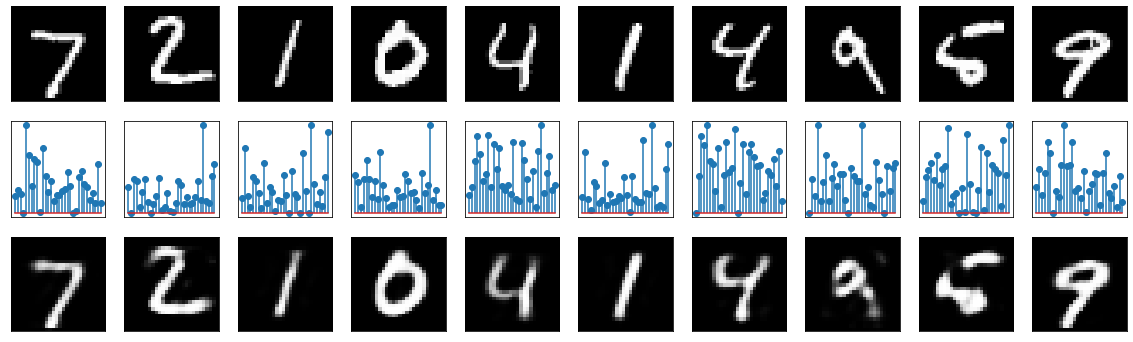

In [11]:
show_ae(simple_AE_model, x_test)

## Convolutional AutoEncoder 실습
fully connected layer 대신에 convolution layer로 이루어진 AutoEncoder 모델을 학습

### (1) 데이터셋 준비
convolution layer에 입력할 수 있도록 (datasample,row, column, channel) 차원으로 reshape

In [12]:
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
print(x_train.shape, x_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


### (2) 모델링

In [13]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Reshape, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

In [14]:
class conv_AE(Model):
    def __init__(self, input_dim=(28,28,1)):
        x = Input(shape=input_dim)  # 28,28,1
        en = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
        en = MaxPooling2D((2, 2), padding='same')(en)
        en = Conv2D(8, (3, 3), activation='relu', padding='same')(en)
        en = MaxPooling2D((2, 2), padding='same')(en)
        en = Conv2D(4, (3, 3), activation='relu', padding='same')(en)
        en = MaxPooling2D((2, 2), padding='same')(en)
        
        z = Flatten()(en) # 64
        
        de = Reshape((4, 4, 4))(z)
        de = Conv2D(4, (3, 3), activation='relu', padding='same')(de)
        de = UpSampling2D((2, 2))(de)
        de = Conv2D(8, (3, 3), activation='relu', padding='same')(de)
        de = UpSampling2D((2, 2))(de)
        de = Conv2D(16, (3, 3), activation='relu')(de)
        de = UpSampling2D((2, 2))(de)
        y = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(de)

        super().__init__(x, y)

        self.x = x
        self.z = z
        self.y =y

    def Encoder(self):
        return Model(self.x, self.z)

    def Decoder(self):
        z = Input(shape=(64,))
        decode_layer = self.layers[-8](z)
        decode_layer = self.layers[-7](decode_layer)
        decode_layer = self.layers[-6](decode_layer)
        decode_layer = self.layers[-5](decode_layer)
        decode_layer = self.layers[-4](decode_layer)
        decode_layer = self.layers[-3](decode_layer)
        decode_layer = self.layers[-2](decode_layer)
        output = self.layers[-1](decode_layer)
        return Model(z, output)

In [15]:
conv_AE_model = conv_AE()
conv_AE_model.compile(optimizer='adam', loss='binary_crossentropy')

In [16]:
conv_AE_model.summary()

Model: "conv_ae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 4)           292       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 4)           0   

### (3) 모델 학습

In [17]:
conv_AE_model.fit(x_train, x_train, epochs=100, batch_size=256, shuffle=True, validation_split=0.2)

Epoch 1/100
188/188 [==============================] - 2s 8ms/step - loss: 0.3050 - val_loss: 0.1950
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 0.1783 - val_loss: 0.1677
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 0.1589 - val_loss: 0.1543
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 0.1484 - val_loss: 0.1455
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 0.1413 - val_loss: 0.1396
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 0.1364 - val_loss: 0.1358
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 0.1331 - val_loss: 0.1328
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 0.1304 - val_loss: 0.1306
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 0.1284 - val_loss: 0.1287
Epoch 10/100
188/188 [==============================] - 1s 6ms/step - loss: 0.1269 - val_lo

### (4) 모델 사용하기

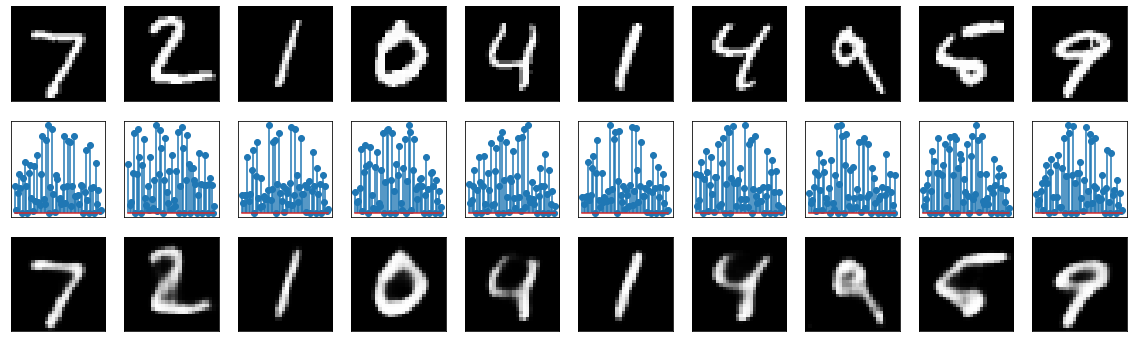

In [18]:
show_ae(conv_AE_model, x_test)

## Denoising AutoEncoder 실습
이미지에 noise를 추가하고 AutoEncoder 모델이 noise가 없는 원래 이미지로 복원하도록 학습

## (1) 데이터셋 준비
이미지에 가우시안 분포를 이루는 noise를 추가

In [19]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

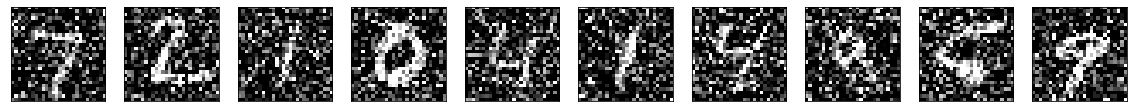

In [20]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## (2) 모델링

In [21]:
class conv_AE_(Model):
    def __init__(self, input_dim=(28,28,1)):
        x = Input(shape=input_dim)  
        en = Conv2D(32, (3, 3), activation='relu', padding='same')(x) 
        en = MaxPooling2D((2, 2), padding='same')(en) 
        en = Conv2D(32, (3, 3), activation='relu', padding='same')(en) 
        en = MaxPooling2D((2, 2), padding='same')(en) 
        en = Conv2D(16, (3, 3), activation='relu', padding='same')(en) 
        en = MaxPooling2D((2, 2), padding='same')(en) 
        
        z = Flatten()(en) 
        
        de = Reshape((4, 4, 16))(z)
        de = Conv2D(16, (3, 3), activation='relu', padding='same')(de)
        de = UpSampling2D((2, 2))(de)
        de = Conv2D(32, (3, 3), activation='relu', padding='same')(de)
        de = UpSampling2D((2, 2))(de)
        de = Conv2D(32, (3, 3), activation='relu')(de)
        de = UpSampling2D((2, 2))(de)
        y = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(de)

        super().__init__(x, y)

        self.x = x
        self.z = z
        self.y =y

    def Encoder(self):
        return Model(self.x, self.z)

    def Decoder(self):
        z = Input(shape=(256,))
        decode_layer = self.layers[-8](z)
        decode_layer = self.layers[-7](decode_layer)
        decode_layer = self.layers[-6](decode_layer)
        decode_layer = self.layers[-5](decode_layer)
        decode_layer = self.layers[-4](decode_layer)
        decode_layer = self.layers[-3](decode_layer)
        decode_layer = self.layers[-2](decode_layer)
        output = self.layers[-1](decode_layer)
        return Model(z, output)

In [22]:
conv_AE_model = conv_AE_()
conv_AE_model.compile(optimizer='adam', loss='binary_crossentropy')
conv_AE_model.summary()

Model: "conv_ae_"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 16)          4624      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 16)          0  

## (3) 모델 학습

In [23]:
conv_AE_model.fit(x_train_noisy, x_train, epochs=100, batch_size=256, shuffle=True, validation_split=0.2)

Epoch 1/100
188/188 [==============================] - 2s 12ms/step - loss: 0.2785 - val_loss: 0.1943
Epoch 2/100
188/188 [==============================] - 2s 8ms/step - loss: 0.1741 - val_loss: 0.1635
Epoch 3/100
188/188 [==============================] - 2s 9ms/step - loss: 0.1536 - val_loss: 0.1476
Epoch 4/100
188/188 [==============================] - 2s 9ms/step - loss: 0.1422 - val_loss: 0.1402
Epoch 5/100
188/188 [==============================] - 2s 9ms/step - loss: 0.1355 - val_loss: 0.1339
Epoch 6/100
188/188 [==============================] - 2s 9ms/step - loss: 0.1310 - val_loss: 0.1300
Epoch 7/100
188/188 [==============================] - 2s 9ms/step - loss: 0.1273 - val_loss: 0.1270
Epoch 8/100
188/188 [==============================] - 2s 8ms/step - loss: 0.1245 - val_loss: 0.1239
Epoch 9/100
188/188 [==============================] - 2s 8ms/step - loss: 0.1223 - val_loss: 0.1220
Epoch 10/100
188/188 [==============================] - 2s 8ms/step - loss: 0.1203 - val_l

## (4) 모델 사용하기

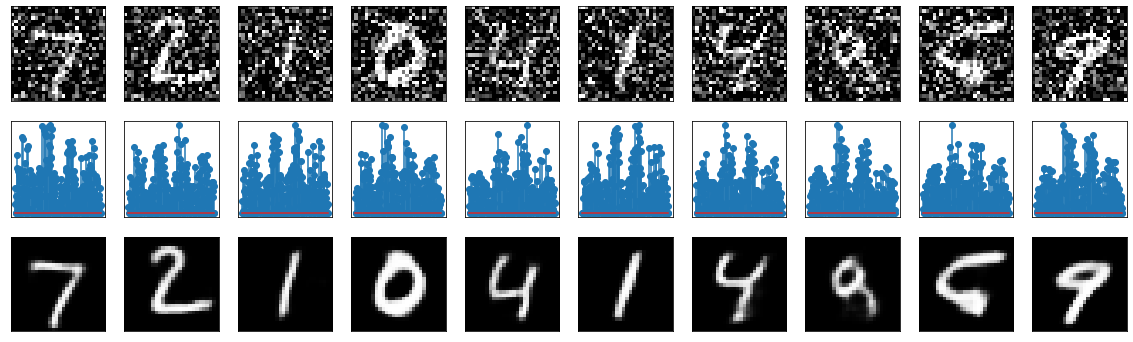

In [24]:
show_ae(conv_AE_model, x_test_noisy)

# Variational AutoEncoder 실습
생성 모델인 Vatiational AutoEncoder를 mnist 데이터로 학습하고 샘플링

## (1) 데이터셋 준비

In [12]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape, x_test.shape)

(60000, 784) (10000, 784)


In [13]:
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
nb_epoch = 10
epsilon_std = 1.0

## (2) 모델링

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tensorflow.keras.layers import Input, Dense, Lambda, Layer, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
#from tensorflow.keras import objectives
from tensorflow.keras.datasets import mnist
import tensorflow as tf

In [15]:
class Sampling(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [16]:
latent_dim = 2

encoder_inputs = tensorflow.keras.Input(shape=(28, 28, 1))
x = Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = Flatten()(x)
x = Dense(16, activation="relu")(x)
z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = tensorflow.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [17]:
latent_inputs = tensorflow.keras.Input(shape=(latent_dim,))
x = Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = Reshape((7, 7, 64))(x)
x = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

In [18]:
class VAE(tensorflow.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tensorflow.keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [19]:
(x_train, _), (x_test, _) = tensorflow.keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=tensorflow.keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 3s 6ms/step - loss: 212.0941 - reconstruction_loss: 209.7206 - kl_loss: 2.3736
Epoch 2/30
547/547 [==============================] - 3s 6ms/step - loss: 185.4906 - reconstruction_loss: 183.1169 - kl_loss: 2.3737
Epoch 3/30
547/547 [==============================] - 3s 6ms/step - loss: 176.8131 - reconstruction_loss: 174.0163 - kl_loss: 2.7968
Epoch 4/30
547/547 [==============================] - 3s 6ms/step - loss: 162.4299 - reconstruction_loss: 158.7195 - kl_loss: 3.7103
Epoch 5/30
547/547 [==============================] - 3s 6ms/step - loss: 158.1113 - reconstruction_loss: 154.2784 - kl_loss: 3.8330
Epoch 6/30
547/547 [==============================] - 3s 6ms/step - loss: 156.0025 - reconstruction_loss: 152.1359 - kl_loss: 3.8666
Epoch 7/30
547/547 [==============================] - 3s 6ms/step - loss: 154.6616 - reconstruction_loss: 150.7877 - kl_loss: 3.8738A: 0s - loss: 154.6528 - reconstruction_loss: 150.7751 - kl_l
Epoch 8/

## (3) 모델 학습

## (4) 모델 사용하기

In [20]:
def plot_latent(encoder, decoder):
    # display a n*n 2D manifold of digits
    n = 30
    digit_size = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

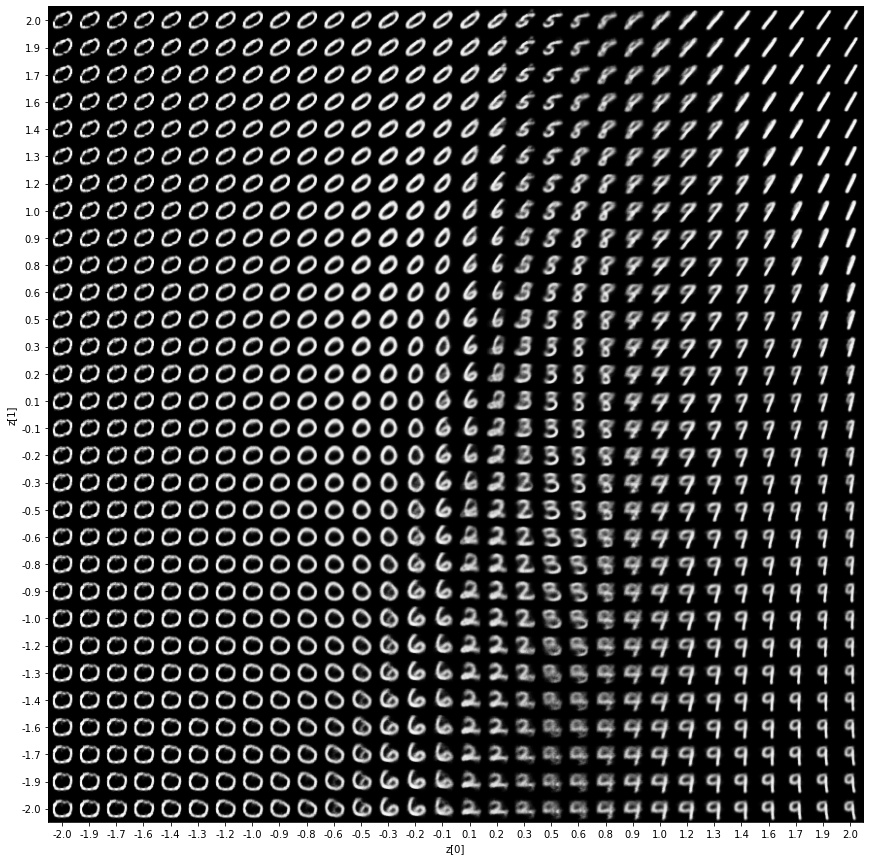

In [21]:
plot_latent(encoder, decoder)

In [22]:
def plot_label_clusters(encoder, decoder, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels, cmap='jet')
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

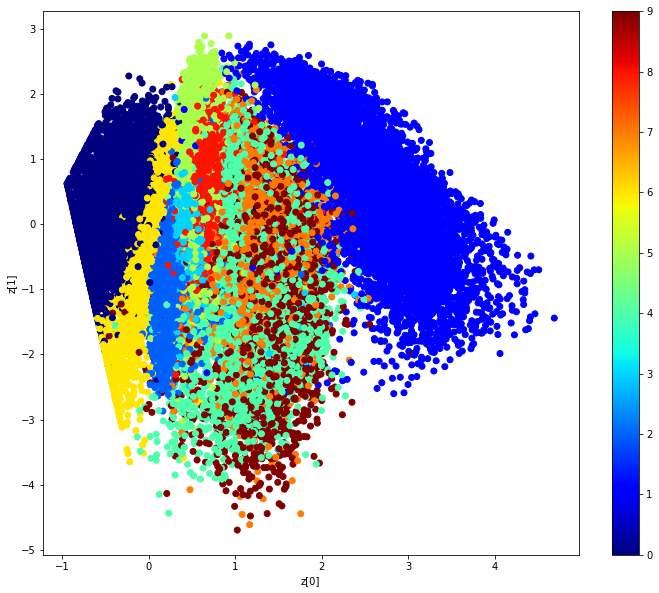

In [24]:
(x_train, y_train), _ = tensorflow.keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(encoder, decoder, x_train, y_train)